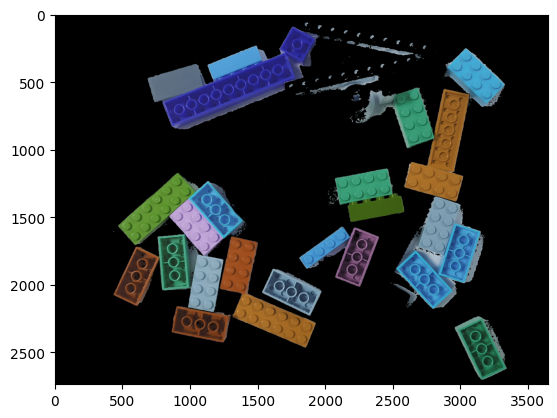

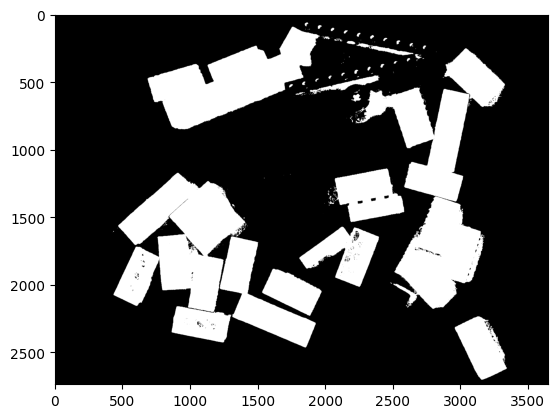

In [10]:
# 用LAB进行阈值分割
import numpy as np
from matplotlib import pyplot as plt
import cv2

image = cv2.imread("../test_images/7.jpg")
lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

# Split into L, A, and B channels
l_channel, a_channel, b_channel = cv2.split(lab_image)

# 设置 A* 和 B* 的阈值范围，根据MATLAB中色彩分割测试确定
l_min, l_max = 0, 100
a_min, a_max = -7, 7
b_min, b_max = -7, 7

# 将MATLAB中 A* 和 B* 的阈值转换到 OpenCV LAB 空间
l_min_cv = l_min / 100 * 255
l_max_cv = l_max / 100 * 255
a_min_cv = (a_min + 100) / 200 * 255
a_max_cv = (a_max + 100) / 200 * 255
b_min_cv = (b_min + 100) / 200 * 255
b_max_cv = (b_max + 100) / 200 * 255

binary = cv2.inRange(lab_image, (l_min_cv, a_min_cv, b_min_cv), (l_max_cv, a_max_cv, b_max_cv))
binary = cv2.bitwise_not(binary)
masked_image = cv2.bitwise_and(image, image, mask=binary)

plt.figure(1)
plt.imshow(masked_image, cmap='gray')
plt.figure(2)
plt.imshow(binary, cmap='gray')

plt.show()

Total Connected Components (Foreground Objects): 15


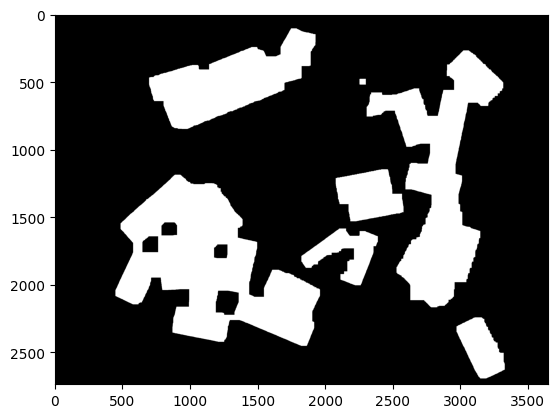

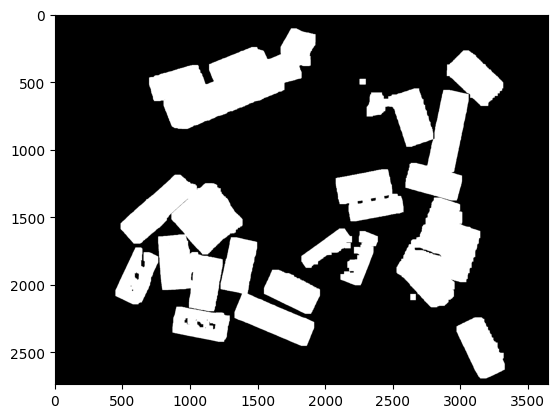

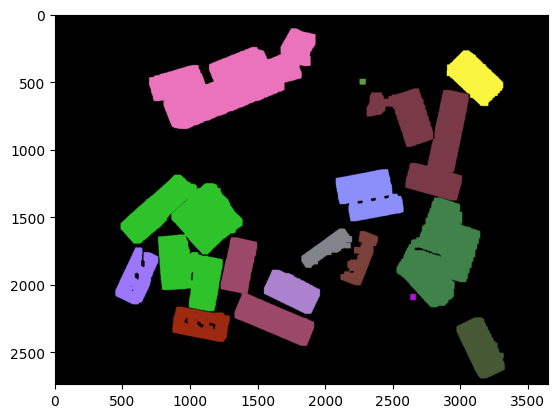

In [11]:
# 确定Sure Foreground
import numpy as np
from matplotlib import pyplot as plt
import cv2

# 预处理
# 除二值图像噪点
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=4)
opening = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=7)  # 补漏洞

# 获取前景
# 方法1：距离变换
# dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
# _, sure_fg = cv2.threshold(dist_transform, 0.4*dist_transform.max(), 255, cv2.THRESH_BINARY)
# sure_fg = np.uint8(sure_fg)
# 方法2：腐蚀
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))
sure_fg = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=4)

num_labels, labels = cv2.connectedComponents(sure_fg)

# 创建一个与原图像大小相同的彩色图像
labeled_image = np.zeros_like(image)
# 获取不同标签的独特颜色
unique_labels = np.unique(labels)
colors = [np.random.randint(0, 255, 3) for _ in unique_labels]

# 给每个连通区域上色
for label, color in zip(unique_labels, colors):
    if label == 0:  # 跳过背景标签
        continue
    labeled_image[labels == label] = color

print(f"Total Connected Components (Foreground Objects): {num_labels - 1}")

plt.figure(1)
plt.imshow(opening, cmap='gray')
plt.figure(2)
plt.imshow(sure_fg, cmap='gray')
plt.figure(3)
plt.imshow(cv2.cvtColor(labeled_image, cv2.COLOR_BGR2RGB))

In [ ]:
# 用K-means对颜色分类，启发式寻找每个连通区域的分类数
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator

# 获取不同标签的独特颜色
for label_of_interest in np.unique(labels):
    if label_of_interest == 0:  # 无视背景
        continue

    mask = np.where(labels == label_of_interest, 255, 0).astype('uint8')

    test_image = cv2.bitwise_and(image, image, mask=mask)

    # Reshape the image to be a list of pixels
    pixels = test_image.reshape(-1, 3)
    pixels = pixels[~np.all(pixels == 0, axis=1)]   # 除去0向量

    # Define criteria and apply kmeans()
    # The criteria (type, max_iter, epsilon)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    # Number of clusters (K)
    k_values = list(range(1, 6))
    sse = []  # Sum of squared errors

    for k in k_values:
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        kmeans.fit(pixels)
        sse.append(kmeans.inertia_)

    # 使用 KneeLocator 来确定肘部位置
    knee_locator = KneeLocator(k_values, sse, curve='convex', direction='decreasing')

    # 肘部位置是最佳的聚类数量
    elbow_point = knee_locator.elbow

    # Plotting the results onto a line graph to observe the elbow
    plt.figure(label_of_interest)
    plt.plot(k_values, sse, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow Method For Optimal k')
    if elbow_point is not None:
        plt.axvline(x=elbow_point, color='red', linestyle='--')

    plt.savefig(f'../cluster/5-{label_of_interest}.png')

plt.show()


c:\Users\huigg\anaconda3\envs\pytorch\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Color 0: 1.98%
Color 1: 22.36%
Color 2: 13.44%
Color 3: 10.34%
Color 4: 17.79%
Color 5: 7.47%
Color 6: 5.00%
Color 7: 0.59%
Color 8: 5.87%
Color 9: 15.17%


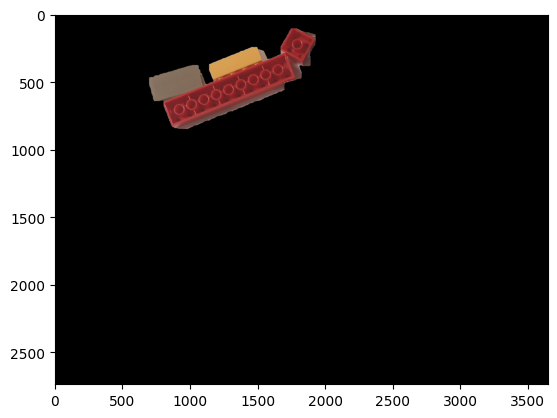

In [14]:
# 用K-means对颜色分类，寻找主要颜色
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

mask = np.where(labels == 1, 255, 0).astype('uint8')

test_image = cv2.bitwise_and(image, image, mask=mask)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

# Reshape the image to be a list of pixels
pixels = test_image.reshape(-1, 3)
pixels = pixels[~np.all(pixels == 0, axis=1)]   # 除去0向量

# 使用KMeans算法来找到主要颜色
kmeans = KMeans(n_clusters=10)  # 假设我们想要的主要颜色数量是5
kmeans.fit(pixels)

# 计算每个主要颜色的占比
unique, counts = np.unique(kmeans.labels_, return_counts=True)
color_ratios = {k: v / pixels.shape[0] for k, v in zip(unique, counts)}

# 打印颜色及其占比
for color, ratio in color_ratios.items():
    print(f"Color {color}: {ratio:.2%}")

plt.imshow(test_image)
plt.show()

Total Foreground Objects of 1.jpg: 18
Total Foreground Objects of 2.jpg: 1
Total Foreground Objects of 3.jpg: 2
Total Foreground Objects of 4.jpg: 23
Total Foreground Objects of 5.jpg: 13
Total Foreground Objects of 6.jpg: 22
Total Foreground Objects of 7.jpg: 15


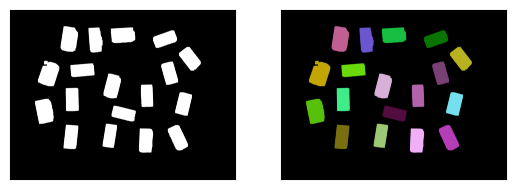

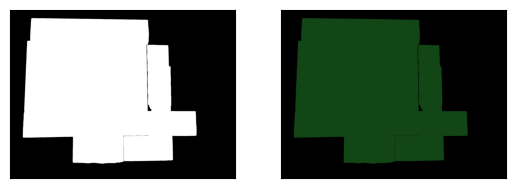

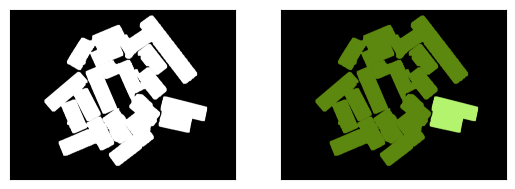

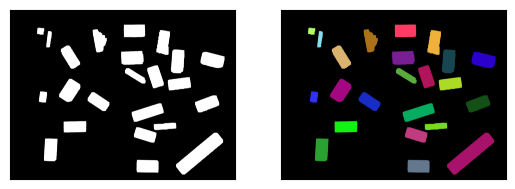

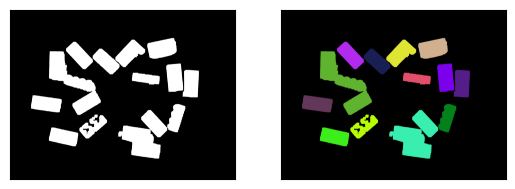

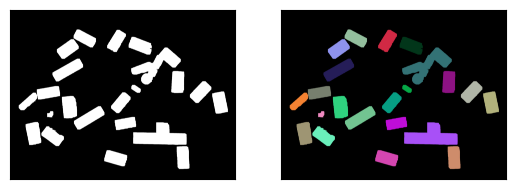

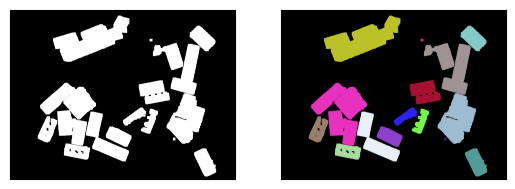

In [1]:
# 用LAB进行阈值分割(For 1~7)
import numpy as np
from matplotlib import pyplot as plt
import cv2

for i in range(1, 8):
    '''
        LAB颜色空间分割图像
    '''
    image = cv2.imread(f"../test_images/{i}.jpg")
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Split into L, A, and B channels
    l_channel, a_channel, b_channel = cv2.split(lab_image)

    # 设置 A* 和 B* 的阈值范围，根据MATLAB中色彩分割测试确定
    l_min, l_max = 0, 100
    a_min, a_max = -7, 7
    b_min, b_max = -7, 7

    # 将MATLAB中 A* 和 B* 的阈值转换到 OpenCV LAB 空间
    l_min_cv = l_min / 100 * 255
    l_max_cv = l_max / 100 * 255
    a_min_cv = (a_min + 100) / 200 * 255
    a_max_cv = (a_max + 100) / 200 * 255
    b_min_cv = (b_min + 100) / 200 * 255
    b_max_cv = (b_max + 100) / 200 * 255

    binary = cv2.inRange(lab_image, (l_min_cv, a_min_cv, b_min_cv), (l_max_cv, a_max_cv, b_max_cv))
    binary = cv2.bitwise_not(binary)

    # 操作1：生成掩膜覆盖原图图像，遮蔽部分为黑色
    # masked_image = cv2.bitwise_and(image, image, mask=binary)

    # 操作2：生成掩膜覆盖原图图像，遮蔽部分为白色（接近背景颜色）
    white_image = np.ones_like(image) * 195
    white_masked = cv2.bitwise_and(white_image, white_image, mask=binary)
    masked_image = cv2.bitwise_and(image, image, mask=cv2.bitwise_not(binary))

    # 将两个图像合并
    masked_image = cv2.add(white_masked, masked_image)

    '''
        获取Sure Foreground
    '''
    # 除二值图像噪点
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=4)
    opening = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=7)  # 补漏洞

    # 获取前景
    # 方法1：距离变换
    # dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    # _, sure_fg = cv2.threshold(dist_transform, 0.4*dist_transform.max(), 255, cv2.THRESH_BINARY)
    # sure_fg = np.uint8(sure_fg)
    # 方法2：腐蚀
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))
    sure_fg = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=4)

    num_labels, labels = cv2.connectedComponents(sure_fg)

    # 创建一个与原图像大小相同的彩色图像
    labeled_image = np.zeros_like(image)
    # 获取不同标签的独特颜色
    unique_labels = np.unique(labels)
    colors = [np.random.randint(0, 255, 3) for _ in unique_labels]

    # 给每个连通区域上色
    for label, color in zip(unique_labels, colors):
        if label == 0:  # 跳过背景标签
            continue
        labeled_image[labels == label] = color

    print(f"Total Foreground Objects of {i}.jpg: {num_labels - 1}")

    cv2.imwrite(f'../masked_images/{i}.jpg', masked_image)
    # plt.figure(i)
    # plt.imshow(binary, cmap='gray')
    cv2.imwrite(f'../masked_images/{i}-colored.jpg', labeled_image)
    plt.figure(i)
    plt.subplot(1, 2, 1), plt.xticks([]), plt.yticks([])
    plt.imshow(sure_fg, cmap='gray')
    plt.subplot(1, 2, 2), plt.xticks([]), plt.yticks([])
    plt.imshow(cv2.cvtColor(labeled_image, cv2.COLOR_BGR2RGB))
    
plt.show()

In [11]:
# 尝试去除背景
import numpy as np
from matplotlib import pyplot as plt
import cv2
from PIL import Image
from rembg import remove, new_session

input_path = '../masked_images/4.jpg'
output_path = '../rembg/4.png'

input = Image.open(input_path)

model_name = "sam"
session = new_session(model_name)

# 使用 rembg 去除背景
# output = remove(input)
# output = remove(input, alpha_matting=True, alpha_matting_foreground_threshold=270,alpha_matting_background_threshold=20, alpha_matting_erode_size=11)
# output = remove(input, only_mask=True)

# 转换二值数组为PIL图像
binary_mask = Image.fromarray(binary.astype(np.uint8) * 255)
output = remove(input, mask=binary_mask,  session=session, post_process_mask=True)
output.save(output_path)


ValidationError: '{}' is not of type 'array'

Failed validating 'type' in schema:
    {'items': {'properties': {'data': {'items': {'type': 'number'},
                                       'type': 'array'},
                              'label': {'type': 'integer'},
                              'type': {'type': 'string'}},
               'type': 'object'},
     'type': 'array'}

On instance:
    '{}'